In [1]:
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.2 MB/s 


In [2]:
bUseColab = True

In [3]:
if (bUseColab):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


# 14.4. Anchor Boxes



- 객체 감지(Object Detection) 알고리즘은 입력 이미지에서 많은 수의 영역을 샘플링(Sampling)하고 영역에 관심 객체(Object of interest)가 포함되어 있는지 확인하고, 객체의 Ground-Truth Bounding box를 더 정확하게 예측하기 위해 영역의 경계를 표시하여 구분한다.

- Anchor Boxes : 각 픽셀을 중심으로 다양한 크기(varying scales)와 종횡비(aspect ratios)를 가진 여러 경계 상자를 생성 함. 이러한 경계 박스들을 Anchor Box라 칭함.


In [4]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # Simplify printing accuracy (소수점 2자리 까지 표시)

## 14.4.1. Generating Multiple Anchor Boxes



입력된 image size를 (w, h)라고 하였을 때, 우리는 이미지의 각각의 픽셀의 중심으로 하는 다른 모양의 Anchorbox를 생성할 수 있다. 

* *scale* be $s\in [0, 1]$.  
* *aspect ratio* (ratio of width to height) is $r > 0$.  

임의의 중심점에 주어 졌을 때, Anchor Box의 Width와 Height는 다음과 같이 나타낸다.

* width of the anchor = $ws\sqrt{r}$  
* height of the anchor = $hs/\sqrt{r}$  

Multiple Anchor box들을 생성하기 위해, 스케일과 종횡비를 여러개로 둘 수 있다. 

* a series of scales : $s_1,\ldots, s_n$  
* a series of aspect ratios : $r_1,\ldots, r_m$.  

모든 픽셀에 대해 Scale과 Aspect Ratio들의 경우의 수를 결합하면 총 $whnm$ 개의 anchor boxes가 생성될 것이다. 
이러한 경우, Ground truth bounding box를 커버할지라도, 계산의 복잡도는 매우 높아질 것이다. 

따라서, 우리는 $s_1$, $r_1$를 포함하는 조합만 고려할 수 있다.   
(Ratio는 S1에 대해서만 고려하고, Scale은 r1에 대해서만 고려한다.)

(**$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$**)

* $s_1$에 대해서 $r_1$, $\ldots$, $r_m$ > m 개  
* $r_1$에 대해서 $s_2$, $\ldots$, $s_n$ > n-1 개
* 동일한 픽셀을 중심으로하는 Anchor box의 수 : $n+m-1$
* 전체 Anchor box의 수 $wh(n+m-1)$
* 아래 `multibox_prior` 함수에서 Anchor boxes를 생성하는 방법이 구현 됨. 

In [5]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

위 함수의 출력 Y의 Shape에 대해서 확인 해보면, 다음과 같다.

* Y.Shape = (**batch size**, **number of anchor boxes**, **4**)

In [6]:
import numpy as np
import matplotlib.pyplot as plt


img = plt.imread('/content/drive/MyDrive/d2l/img/catdog.jpg' if bUseColab else '../img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data               # 2번째 값이 3인 것은 중요하지 않다. 그냥 Rgb를 표현하고자 했던게 아닐까..
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 2042040, 4])

* `Y`를 reshape하여, (image height, image width, number of anchor boxes centered on the same pixel, 4)로 변경하면, 특정 Pixel 좌표를 중심으로 하는 Anchorbox를 얻을 수 있음.  
* number of anchor boxes centered on the same pixel = len(sizes) + len(ratios) - 1 = 5
* Anchor box의 Center를 250, 250으로 하였을 때, 4개의 Elements를 가지고 있음. 
: the $(x, y)$-axis coordinates at the upper-left corner and the $(x, y)$-axis coordinates at the lower-right corner of the anchor box.
* 두 축의 좌표 값은 각각 이미지의 너비와 높이로 나뉩니다. 따라서 범위는 0과 1 사이입니다.

In [7]:
boxes = Y.reshape(h, w, -1, 4)
print('boxes shape : ', boxes.shape)
print('boxes[250, 250, 0, :] : ', boxes[250, 250, 0, :])
bbox_scale = torch.tensor((w, h, w, h))
print('boxes[250, 250, 0, :] : ', boxes[250, 250, 0, :]*bbox_scale)

boxes shape :  torch.Size([561, 728, 5, 4])
boxes[250, 250, 0, :] :  tensor([0.06, 0.07, 0.63, 0.82])
boxes[250, 250, 0, :] :  tensor([ 40.13,  40.12, 460.88, 460.87])


* `show_bboxes` Function : 여러 Bounding box들을 이미지에 그리는 함수를 생성.
* 이 함수를 이용하여 하나의 픽셀을 중심으로하는 모든 Anchor box를 그려볼 예정.

In [8]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

* `boxes`라는 변수의 $x$, $y$ 좌표는 Width와 Height로 나눠져 있음.  
* 이를 원 좌표로 복원하기 위하여, `bbox_scale`를 정의 함.  

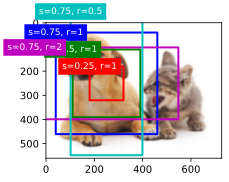

In [9]:
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = figsize=(3.5, 2.5)
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes,
            boxes[250, 250, :, :] * bbox_scale,                     # weight와 height를 곱하여 원 좌표로 복원
            ['s=0.75, r=1',
             's=0.5, r=1', 
             's=0.25, r=1',
             's=0.75, r=2',
             's=0.75, r=0.5'])

## 14.4.2. Intersection over Union (IoU)



* 앵커박스 (Anchor boxes)와 실제 경계 박스(ground-truth bounding box) 사이의 유사성 측정

* 자카드 지수(Jaccard index)는 두 집합 사이의 유사도를 측정하는 방법 중 하나

* 자카드 지수(Jaccard index) = 교집합(intersection)의 크기 / 합집합(union)의 크기 

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

* 자카드 지수는 0과 1 사이의 값을 가지며, 두 집합이 동일하면 1의 값을 가지고, 공통의 원소가 하나도 없으면 0의 값을 가진다

* Jaccard 인덱스를 그림 14.4.1 과 같이 결합 영역에 대한 교차 영역의 비율 **intersection over union( IoU )** 라 한다.

![IoU is the ratio of the intersection area to the union area of two bounding boxes.](https://d2l.ai/_images/iou.svg)
:label:`fig_iou`

In [10]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: 
    # (no. of boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## 14.4.3. Labeling Anchor Boxes in Training Data


* Object Detection model을 학습하기 위해서, 각각의 Anchorbox에 Class와 Offset Labels이 필요함.

    * 앵커 박스와 관련된 Object의 class  
    * 앵커 박스에 상대적인 ground-truth bounding box의 offset

####
* 다음에서 가장 가까운 ground-truth bounding box를 앵커 상자에 할당하는 알고리즘을 설명합니다.


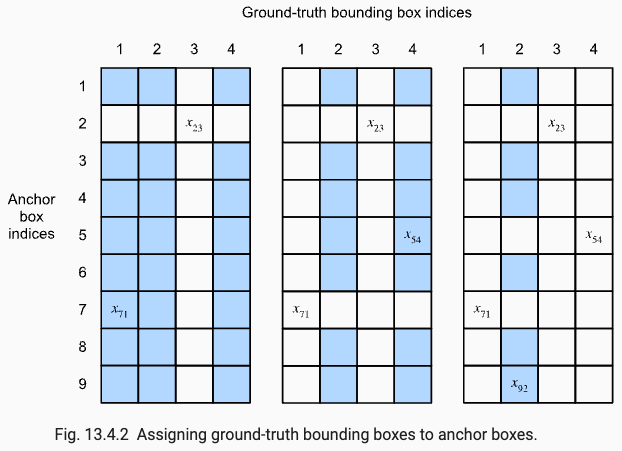


### [**Assigning Ground-Truth Bounding Boxes to Anchor Boxes**]


* A : Anchor box ($A_1, A_2, \ldots, A_{n_a}$)
* B : ground-truth bounding box ($B_1, B_2, \ldots, B_{n_b}$)
* where $n_a \geq n_b$.

* matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$
* element $x_{ij}$ = IoU of the  $A_i$ and $B_j$

1. matrix $\mathbf{X}$에서 가장 큰 element를 찾는다.  
   그 요소의 행과 열을 $i_1$ and $j_1$라 하자.
   (직관적으로 모든 Anchor box와 Bounding box사이에 가장 근접한 박스가 된다.)
   ground-truth box $B_{j_1}$, anchor box인 $A_{i_1}$  
   이후 행렬에서 ${i_1}^\mathrm{th}$ 행과, ${j_1}^\mathrm{th}$ 열의 모든 element를 버림.

2. 행렬 X에서 그다음으로 큰 element를 찾아서 역시 같은 방식으로 할당 후 제거.

3. 이 과정을 모든 열에서 반복

4. 나머지 $n_a - n_b$개의 anchor box들은 threshold를 넘는지 확인하여 ground-truth bounding box에 할당할지 고려.

아래와 같이, 

1. matrix $\mathbf{X}$에서 $x_{23}$이 가장 큰 값이라고 가정해 보자.  
   ( ground-truth bounding box $B_3$ / anchor box $A_2$. )
  
1. 그런 다음 2번째 행과 3번째 열의 모든 요소를 버린다.  
   
1. 남은 영역(색칠된 영역)에서 가장 큰 요소 $x_{71}$ 를 찾는다.  
   ( ground-truth bounding box $B_1$ / anchor box $A_7$. )

1. 그런 다음 7번째 행과 1번째 열의 모든 요소를 버린다. 

1. 동일하게 반복하여, $x_{54}$, $x_{92}$를 찾는다. 

1. 그런 다음 남아 있는 Anchor box ($A_1, A_3, A_4, A_6, A_8$)에 대해서,  
 Threshold에 따라 ground-truth bounding boxes를 할당할지 여부를 결정합니다.




![Assigning ground-truth bounding boxes to anchor boxes.](https://d2l.ai/_images/anchor-label.svg)

이 알고리즘은 다음 `assign_anchor_to_bbox` 함수에서 구현 됨.


In [11]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### Labeling Classes and Offsets

* anchor box $A$의 Class는 ground-truth bounding box $B$라고 하였을 때, 
* anchor box $A$의 Offset은 $B$와 $A$의 상대적인 크기와 함께, 중심점 사이의 상대적인 좌표를 통해 계산 됨.

* A의 좌표 : $(x_a, y_a)$ / B의 좌표 : $(x_b, y_b)$ 이렇게 주어졌을 때, 
 
We may label the offset of $A$ as
$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

where default values of the constants are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$.

위 계산을 `offset_boxes` function에서 구현 함.

In [12]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [13]:
# 좌표 변환해주는 함수. 
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = d2l.stack((cx, cy, w, h), axis=-1)
    return boxes
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = d2l.stack((x1, y1, x2, y2), axis=-1)
    return boxes
# ex. 
boxcorner = torch.tensor([[0, 0.1, 0.2, 0.3]])
boxcenter = box_corner_to_center(boxcorner)
boxcorner = box_center_to_corner(boxcenter)
print(boxcorner, boxcenter)

tensor([[0.00, 0.10, 0.20, 0.30]]) tensor([[0.10, 0.20, 0.20, 0.20]])


In [14]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

만약 Anchorbox가 ground_truth bounding box와 매칭 되지 않을 경우는 Backgound로 처리
(Threshold를 넘기지 못한 경우)|

* Background Anchor box : Negative anchor_box
* Class Anchor box : Positive anchor_box

`multibox_target` 함수를 통해, 
ground-truth bounding box (label argument)를 사용해서 anchor box의 class를 labeling하고, offset을 계산 함.

배경을 0으로 하고, class를 1씩 증가시킴.


In [15]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### An Example

* 예시를 통해 확인해 보자.

torch.Size([5, 4]) torch.Size([2, 5])


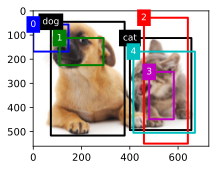

In [16]:
# Class : Dog (0), Cat (1)을 첫번째 Element로 주었다. 
# 나머지 4개의 요소는 (Left, top, right, bottom) - range is between 0 and 1
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

print(anchors.shape, ground_truth.shape)
fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

위에서 정의한 `multibox_target` 함수를 통해 ground-truth bounding box (label argument)를 사용해서 anchor box의 class를 labeling하고, offset을 계산 함.

In [17]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))
[bbox_offset, bbox_mask, class_labels] = labels
print('bbox_offset :', bbox_offset.reshape(-1,4))
print('bbox_mask :', bbox_mask.reshape(-1,4))
print('class_labels :', class_labels)


bbox_offset : tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        [-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])
bbox_mask : tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])
class_labels : tensor([[0, 1, 2, 0, 2]])


첫번째 항목에는 각각의 Anchor Box를 Labeling하는 offset Value가 저장됨. (이 때 Nagative class offset은 0으로 지정)

두번째 항목에서 Mask 변수를 나타내고

마지막 항목에서 0,1,2 형태로 Labeling 최종값을 보여줌

예측하는 동안 다수의 Anchorbox를 생성하고, 각각에 대한 Class와 offset을 예측하여 이에따라 Bounding box의 좌표를 구현함.


## 14.4.4. Predicting Bounding Boxes with Non-Maximum Suppression


* Sliding window를 통해 각 patch별로 scoring을 하게 되면, 사실 YOLO등 최근의 알고리즘이라고 해도 모두 갖는 한가지 문제가 있습니다. 이미지의 주변에 있는 patch들이 전부 높은 score를 갖게 된다는 점입니다. object 주위로 좋은 score를 갖는 bounding box가 여러개 생기겠죠. 그 중에서 제일 좋은거 하나를 뽑기 위한 방법이 NMS입니다.

* 방법은 심플합니다. 이 object 주변에 존재하는 bounding box 들을 score 기준으로 sorting 해서 제일 좋은거 하나만 남기고 제거하는 것입니다. 당연히 optimal 한 solution이라고 보기는 어렵고, Local maximum을 찾는 방법이라고 볼 수 있습니다.

![Non-max suppression](https://miro.medium.com/max/2000/1*7iP4yuCZ0r4tH-sG5Q7GkA.png)

`offset_inverse` 함수를 통해 Anchor box를 Bounding box로 변환 할 수 있다. 

In [18]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox


NMS가 작동하는 원리는 다음과 같음. predicted bounding box B에서 object detection model은 각 class에 대한 예측 가능성을 계산함. 가장 큰 likelihood를 p라고 표시할 때, 이 확률에 대한 class가 B의 class임. 동일한 이미지에서 얻어진 배경을 제외한 predicted bounding box를 Confidence(p)를 계산.

<img src="https://oopy.lazyrockets.com/api/v2/notion/image?src=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F5b8f3d43-b7a2-4e30-acd3-e3ef7b69ff8e%2FUntitled.png&blockId=a8f2c506-0026-46e3-9177-3a8984b9d8d7" width="300" height="300"/>

1. Detected 된 bounding box 별로 Confidence threshold(𝜖) 이하의 bounding box는 제거한다.
1. 가장 높은 confidence score를 가진 box 순으로 내림차순 정렬하고 아래 로직을 모든 box에 순차적으로 적용
    - 가장 높은 confience score를 가진 box와 곂치는 다른 box를 모두 조사하여 IOU가 특정 threshold 이상인 box를 모두 제거. 즉 IOU(아래 설명)가 일정 이상인 boundingbox는 동일한 물체를 detect 했다고 판단하고 곂치는 box를 제거해 주는 과정
1. 남아 있는 box만 선택한다.

아래 nms 함수는 confidence score를 내림차순으로 정렬하고, 그것의 indices를 반환 함.

In [19]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

* multibox_detection함수는 경계 상자를 예측하는 데 non-maximum suppression을 적용하기 위해 다음을 정의합니다. 
  구현이 조금 복잡하더라도 걱정하지 마십시오. 구현 직후에 구체적인 예제를 통해 어떻게 작동하는지 보여드리겠습니다.

In [20]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

* 위의 구현을 4개의 앵커 상자가 있는 구체적인 예에 ​​적용해 보겠습니다.  
 단순화를 위해 예측된 오프셋이 모두 0이라고 가정합니다.   
 이것은 예측된 경계 상자가 앵커 상자임을 의미합니다.   
 배경, 개, 고양이의 각 클래스에 대해 예측 가능성도 정의합니다.  

In [21]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

* 이러한 predicted bounding boxes를 이미지에 대한 confidence를 그릴 수 있습니다. 

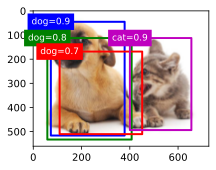

In [22]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

* 이제 multibox_detection가 Threshold가 0.5로 설정된 NMS를 수행하는 함수를 호출할 수 있습니다.
* 반환된 Output의 모양이 (배치 크기, 앵커 상자 수, 6)임을 알 수 있습니다.
  가장 안쪽 차원의 6개 요소는 동일한 예측 경계 상자에 대한 출력 정보를 제공합니다. 
     * 첫 번째 요소는 0부터 시작하는 예측된 클래스 인덱스(0은 개, 1은 고양이).  
       값 -1은 NMS에서 배경 또는 제거.   
     * 두 번째 요소는 예측된 경계 상자의 신뢰도.   
     * 나머지 4가지 요소는 $(x, y)$- 각각 예측된 경계 상자의 왼쪽 위 모서리와 오른쪽 아래 모서리의 축 좌표.(범위는 0에서 1 사이임).

In [23]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

* 클래스 -1의 predicted bounding boxes를 제거한 후 non-maximum suppression에 의해 유지되는 최종 predicted bounding box를 출력할 수 있습니다.

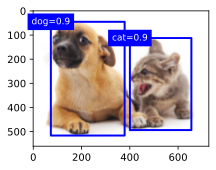

In [24]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

* 실제로, 낮은 confidence로 예측된 predicted bounding boxes을 제거 함으로써, 계산을 줄일 수 있다.   

* 예를 들어 최종 출력에서 더 높은 신뢰도로 결과만 유지함으로써 최대가 아닌 억제의 출력을 후처리할 수도 있습니다.


## 14.4.5. Summary

* 이미지의 각 픽셀을 중심으로 다양한 모양의 앵커 상자를 생성합니다.
* Jaccard 인덱스라고도 하는 IoU(Intersection over Union)는 두 경계 상자의 유사성을 측정합니다. 결합 면적(union area)에 대한 교차 면적(intersection area)의 비율입니다.
* 훈련 세트에서는 각 앵커 상자에 대해 두 가지 유형의 레이블이 필요합니다. 하나는 앵커 박스와 관련된 객체의 클래스이고 다른 하나는 앵커 박스를 기준으로 한 실측 경계 박스의 오프셋(the offset of the ground-truth bounding box)입니다.
* 예측하는 동안 비최대 억제(non-maximum suppression, NMS)를 사용하여 유사한 예측된 경계 상자를 제거하여 출력을 단순화할 수 있습니다.


## 14.4.6. Exercises

1. `multibox_prior`함수에서 `sizes` 와 `ratios` 값을 변경해 보라, Anchor boxes에 어떤 변화가 있는가?

1. IoU가 0.5인 두 개의 bounding box를 구성하고 시각화합니다. 어떻게 서로 겹치나요?

1. 섹션 14.4.3 및 섹션 14.4.4 에서 변수 anchors를 수정합니다. 결과가 어떻게 바뀌나요?

1. Non-maximum suppression는 예측된 경계 상자를 제거함으로써 억제하는 greedy algorithm입니다. 이 제거된 것들 중 일부가 실제로 유용할 수 있습니까? 이 알고리즘을 어떻게 수정하여 부드럽게 억제할 수 있습니까? Soft-NMS [ Bodla et al., 2017 ] 를 참고할 수 있습니다 .
    * https://m.blog.naver.com/jws2218/222077974368 
1. 표준 NMS 알고리즘은 손수 구현되었는데, non-maximum suppression을 학습하게 할 수 있는지?
    * https://arxiv.org/abs/1705.02950


# 14.5. Multiscale Object Detection


* 섹션 14.4 에서 입력 이미지의 각 픽셀을 중심으로 여러 앵커 상자를 생성했습니다. 
#
* 기본적으로 이러한 앵커 상자는 이미지의 다른 영역 샘플을 나타냅니다. 
#
* 그러나 모든 픽셀 에 대해 생성된 경우 계산하기에는 너무 많은 앵커 상자가 생길 수 있습니다. 
#
* **561 X 728의 입력 이미지**가 있다고 하였을 때, **각 픽셀을 중심으로 서로 다른 모양의 5개의 앵커 박스를 생성** 할 경우, **2백만 개가 넘는(561X728X5)의 앵커 박스**를 이미지에 레이블을 지정하고 예측해야 합니다.




## 14.5.1. Multiscale Anchor Boxes


* 입력 이미지에서 픽셀을 균일한 샘플링하여 **샘플링 된 픽셀을 기준으로만 앵커박스를 생성**
    * 이미지에서 Anchor box를 갯수를 줄임. 
    #
* 다양한 Scale의 Anchor box를 생성함으로써, 여러 크기에 대한 객체를 탐지 가능 함.
#
* Boxes를 사용하여 더 작은 개체를 탐지할 때는 더 많은 영역을 표본으로 추출하며, 더 큰 Anchor Boxes를 사용하여 더 큰 개체를 탐지할 때는 더 적은 수의 영역을 표본으로 추출.


In [25]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('/content/drive/MyDrive/d2l/img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

* 섹션 7.2 에서 컨볼루션 레이어의 2차원 배열 출력을 Feature map이라 배웠음.

* Feature map 모양을 정의하여 모든 이미지에서 균일하게 샘플링할 수 있는 anchor box의 중심을 결정할 수 있음.

* display_anchors 함수를 통해 각 유닛(pixel)을 중심으로 feature map (fmap)에 따른 anchor box(anchors)를 생성할 수 있음.  
anchor box의 (x,y) 좌표값을 fmap의 너비와 높이로 나눴으므로 0~1 사이 값이 반환됨.

* anchor box의 중심은 균일하게 분포되어야 하기 때문에, fmap_w 및 fmap_h 값이 주어지면 균일하게 샘플링된 pixel을 중심으로 스케일 s의 anchor box가 각기 다른 비율로 생성됨.

* display_anchors 함수는 feature map의 각 픽셀 단위 중심에 Anchor Boxes를 생성하는 것입니다.

In [26]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 처음 두 차원의 값은 출력에 영향을 주지 않습니다.
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    # fmap의 크기만큼 x, y의 축을 나눠 fmap에서 상대적 위치를 저장합니다.
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    # anchors.shape = torch.Size([1, 48, 4])
    bbox_scale = torch.tensor((w, h, w, h))
    # bbox_scale = [728, 561, 728, 561]
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

In [27]:
# 위에서 설명한 함수로, 지워도 될 것

# data = torch.zeros((1, 10, 4, 4))
# sizes = [0.15]
# ratios = [1, 2, 0.5]
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel.

    Defined in :numref:`sec_anchor`"""
    in_height, in_width = data.shape[-2:]
    # in_height = in_width = 4
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # boxes_per_pixel = 3
    size_tensor = d2l.tensor(sizes, device=device)
    ratio_tensor = d2l.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    # center_h = tensor([0.12, 0.38, 0.62, 0.88])
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # center_w = tensor([0.12, 0.38, 0.62, 0.88])
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    # shift_y = center_w = tensor([[0.12, 0.12, 0.12, 0.12],
    #                              [0.38, 0.38, 0.38, 0.38],
    #                              [0.62, 0.62, 0.62, 0.62],
    #                              [0.88, 0.88, 0.88, 0.88]])
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # shift_y = center_w = tensor([0.12, 0.12, 0.12, 0.12, 0.38, 0.38, 0.38, 0.38, 0.62, 0.62, 0.62, 0.62,
    #                              0.88, 0.88, 0.88, 0.88])

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    # w = tensor([0.15, 0.21, 0.11])
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # h = tensor([0.15, 0.11, 0.21])
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)


먼저 작은 물체를 감지하는 방법을 살펴보겠습니다. 표시될 때 구별하기 쉽도록 여기에서 중심이 다른 앵커 상자는 겹치지 않습니다. 앵커 상자 스케일은 0.15로 설정되고 기능 맵의 높이와 너비는 4로 설정됩니다. 중심이 표시되는 것을 볼 수 있습니다. 이미지의 4행 4열의 앵커박스가 균일하게 분포되어 있습니다.

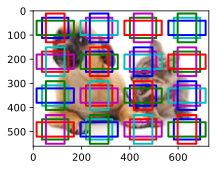

In [28]:
# 작은 물체 검출 : Scale을 0.15로 설정하고, feature map의 height, width을 4로 설정.
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

계속해서 기능 맵의 높이와 너비를 절반으로 줄이고 더 큰 앵커 상자를 사용하여 더 큰 객체를 감지합니다. 배율을 0.4로 설정하면 일부 앵커 상자가 서로 겹칩니다.

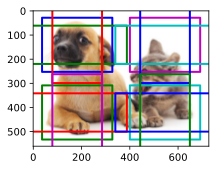

In [29]:
# 조금 더 큰 물체를 검출 
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

마지막으로 기능 맵의 높이와 너비를 절반으로 줄이고 앵커 상자 크기를 0.8로 늘립니다. 이제 앵커 상자의 중심이 이미지의 중심이 됩니다.

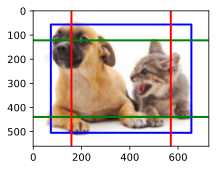

In [30]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [31]:
img = d2l.plt.imread('/content/drive/MyDrive/d2l/img/catdog.jpg' if bUseColab else '../img/catdog.jpg')
h, w = img.shape[0:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print(Y.shape)

561 728
torch.Size([1, 2042040, 4])



## 14.5.2. Multiscale Detection


* 위와 같은 방식으로 multi scale에서 다양한 크기의 Anchor Boxes를 생성할 수 있습니다.  

* 생성된 Anchor Boxes를 통해 다양한 scale에서 다양한 size의 객체를 감지 할 수 있습니다. 


* 14.7절에서 구현할 CNN기반 다중 스케일 객체 감지 방법을 소개

* $C_{i}$ feature map이 입력 이미지를 기반으로 한 **CNN의 중간 출력**

* $C_{i}$ feature map은 서로 다른 공간 위치를 가지며, feature map의 $C_{i}$ 단위는 입력 이미지와 동일한 field를 가집니다.  
따라서 $C_{i}$ 단위를 중간점으로 사용하여 Anchor Boxes의 category와 offset으로 변환할 수 있습니다.  


## 14.5.3. Summary


* 여러 스케일에서 다양한 크기의 물체를 감지하기 위해 **다양한 크기의 앵커 박스를 생성**할 수 있습니다.  

* feature map의 모양을 정의하여 모든 이미지에서 **균일하게 샘플링된 앵커 상자의 중심을 결정**할 수 있습니다.  

* 우리는 특정 receptive field에 있는 입력 이미지의 정보를 사용하여 입력 이미지에서 해당 수신 필드에 가까운 앵커 상자의 클래스와 오프셋을 예측합니다.  

* 딥 러닝을 통해 다중 스케일 객체 감지를 위해 여러 수준에서 **이미지의 레이어별 표현을 활용** 할 수 있습니다.  


## 14.5.4. Exercises


1. 섹션 8.1 의 논의에 따르면 심층 신경망은 이미지에 대한 추상화 수준이 높아짐에 따라 계층적 특징을 학습합니다. multiscale object detection에서 서로 다른 스케일의 feature map이 서로 다른 추상화 수준에 해당합니까? 그 이유는 무엇?

1. 섹션 14.5.1 의 실험에서 first scale(fmap_w=4, fmap_h=4)에서 겹칠 수 있는 균일하게 분포된 앵커 박스를 생성합니다.

1. feature map variable shape = $1 \times c \times h \times w$   
   ($c$ = 채널수, $h$ = Feature map의 height, $w$ = Feature map의 weight)  
   이 변수를 앵커 박스의 클래스와 오프셋으로 어떻게 변환할 수 있습니까? 출력의 모양은 무엇입니까?

[Discussions](https://discuss.d2l.ai/t/1607)



# 14.6. The Object Detection Dataset


* 객체 감지 분야에는 MNIST, Fashion-MNIST와 같은 작은 데이터 세트가 없음.   
  그래서, 빠른 시연을 위해 작은 데이터 셋을 이용해 레이블을 지정.  

    * 바나나 사진을 찍어 회전과 크기가 다른 1000개의 바나나 이미지를 생성  
    * 그런 다음 각 바나나 이미지를 배경 이미지의 임의 위치에 배치  
    * 이미지에서 해당 바나나에 대한 경계 상자에 레이블을 지정  


## 14.6.1. Downloading the Dataset


In [32]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l


* banana detection dataset download (image와 csv label 파일)

In [33]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')


## 14.6.2. Reading the Dataset


데이터 세트
* 왼쪽 상단 및 오른쪽 하단 모서리에 있는 객체 클래스 레이블 
* ground-truth 경계 상자 좌표에 대한 csv 파일이 포함

In [34]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

* 위 `read_data_bananas` 함수를 이용해 Banana Dectection Dataset을 불러오기 위한 사용자 지정 Dataset instance를 생성. 

In [35]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

* `load_data_bananas` 함수를 정의
* Batch_size에 맞게 Train/Validation Set에 대한 DataLoader를 반환하는 함수 정의.

In [36]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

**read a minibatch and print the shapes of both images and labels**


* image minibatch shape
    * (batch size, number of channels, height, width)

* label minibatch shape
    * (batch size, $m$, 5) 
    * 5: 4 offset value + 1 class label. 일 것 같습니다...
    * $m$: 가능한 가장 큰 bounding box 개수

* mini-batch 생성 시
    * 하나의 image 내 bounding box의 수는 다양할 수 있으므로,
    * $m$ 이하의 데이터는 `illegal bounding boxes`로 패딩함 /
    * 각각의 bounding box array length: 5
        * 1: class label / `illegal bounding boxes`일 시 -1
        * 4: offset values (range: 0~1)
    * 본 데이터셋에서 m=1

In [37]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))


## 14.6.3. Demonstration


* 레이블이 지정된 ground-truth 경계 상자가 있는 10개의 이미지  
* 이 모든 이미지에서 바나나의 회전(Rotation), 크기(Size) 및 위치(Position)가 다양함. 
* 실제로 실제 데이터 세트는 일반적으로 훨씬 더 복잡함. 

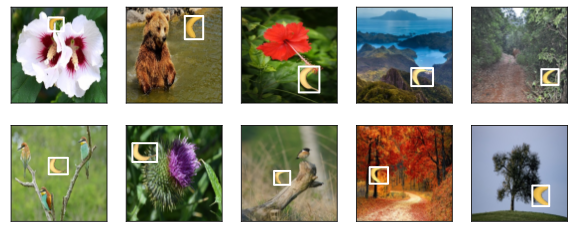

In [38]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])


## 14.6.4. Summary


* banna detection dataset은 object detection model 검증을 위해 사용할 수 있음.

* 객체 감지(object detection)를 위한 데이터 로딩(Data loader (iterator))은 image classification와 유사 함.   
  그러나 객체 감지(object detection)에서 레이블에는 image classification에서 누락된 ground-truth bounding box의 정보도 포함 됨.


## 14.6.5. Exercises


1. 바나나 감지 데이터 세트에서 실측 경계 상자가 있는 다른 이미지를 보여줍니다. 경계 상자 및 개체와 관련하여 어떻게 다릅니까?

1. 임의 자르기와 같은 데이터 증대를 객체 감지에 적용하고 싶다고 가정해 보겠습니다. 이미지 분류에서와 어떻게 다를 수 있습니까? 힌트: 자른 이미지에 개체의 작은 부분만 포함되어 있으면 어떻게 될까요?


# 14.7. Single Shot Multibox Detection


* 단일 샷 멀티박스 감지(SSD)을 적용하여 객체 탐지 구현 [ Liu et al., 2016 ].
* 이것은 객체 감지 모델 중 하나지만, 이 섹션의 일부 설계 원칙 및 구현 세부 정보는 다른 모델에도 적용 됨.

![object Detection milestone](https://pica.zhimg.com/v2-9c141be22bf88ea939a604d61220ba77_1440w.jpg?source=172ae18b)


![One-stage detectors](https://wikidocs.net/images/page/163640/Fig_2_stage.png)  

![Two-stage detectors](https://wikidocs.net/images/page/163640/Fig_1_stage.png)


## 14.7.1. Model


![As a multiscale object detection model, single-shot multibox detection mainly consists of a base network followed by several multiscale feature map blocks.](https://d2l.ai/_images/ssd.svg)

* 그림 14.7.1 은 single-shot multibox detection의 개요를 제공

* 이 모델은 base network + 여러 multiscale feature map 블록으로 구성
    #
    * Base Network : input image에서 feature를 추출 / CNN model 이용 (e.g. VGG net, Resnet)
        * network output: larger feature maps
    #
    * multiscale featur map block: 이전 feature map의 height and width 축소 (e.g. half)
        * 그림 14.7.1 부분의 multiscale feature map은 작지만, 더 큰 receptive field를 갖고 있기 때문에, image상의 큰 object를 detection 하는데 적합함
        * receptive field : 외부 자극이 전체 영향을 끼치는 것이 아니라 특정 영역에만 영향을 준다는 뜻, 하나의 unit에 영향을 주는 input space
#
* several multiscale feature map blocks : 다양한 사이즈의 anchor boxes 생성  
#
* 생성된 anchor boxes의 class와 offset 예측 --> multiscale object detection


![SSD: Single Shot MultiBox Detector](https://lilianweng.github.io/posts/2018-12-27-object-recognition-part-4/SSD-architecture.png)

![feature map](https://velog.velcdn.com/images%2Fdongjae0324_%2Fpost%2F5a48b44d-4106-4489-9b3b-4a4c35d818ac%2Fimage.png)

> Feature Map의 크기가 작아지는 특성을 사용하여 고정된 bounding box로 더 넓은 객체를 인식  
> 이미지가 작아지는 것이 아니라 feature map이 함축적으로 변화되면서 더 넓은 범위를 표현한다고 생각


### **Class Prediction Layer**



* $q$ : number of object classes  
    --> *anchor boxes have $q+1$ classes (class 0: background)
* $h$, $w$ : height and width of feature maps
* $a$ : anchor boxes with each spartial position of these feature maps (e.g. pixel 하나 에서의 anchor box 수)
* $hwa$ : total anchor boxes need to be classified
    * parameter 수가 많아, fully-connected layer로 불가능

**class prediction layer**


* 이 layer에서는 $3\times3$ convolutonal layer를 사용. (padding이 1)
    * 입력과 출력의 크기가 동일. (Feature map의 사이즈를 변경하지 않는 convolution layer 사용)

* 일대일 대응 (one-to-one correspondence) : outputs-inputs의 동일한 spartial dimensions
* 임의의 output feature map channel의 (x, y) --> input feature map의 (x,y)를 축으로한 모든 anchor box에 대한 class 예측임  
  prediction: $a(q + 1)$ output channels 필요: (anchor boxes * classes 의 output channel)  
  동일한 spartial position에서 index $i(q+1) + j$ : anchor box $i (0 \leq i \lt a)$ 에 대한 class $j(0 \leq j \leq q)$의 예측을 뜻함


Specifically,
the class prediction layer uses a convolutional layer
without altering width or height of feature maps.
In this way,
there can be a one-to-one correspondence
between outputs and inputs
at the same spatial dimensions (width and height)
of feature maps.
More concretely,
channels of the output feature maps
at any spatial position ($x$, $y$)
represent class predictions
for all the anchor boxes centered on
($x$, $y$) of the input feature maps.
To produce valid predictions,
there must be $a(q+1)$ output channels,
where for the same spatial position
the output channel with index $i(q+1) + j$
represents the prediction of
the class $j$ ($0 \leq j \leq q$)
for the anchor box $i$ ($0 \leq i < a$).

Below we define such a class prediction layer,
specifying $a$ and $q$ via arguments `num_anchors` and `num_classes`, respectively.
Tihis layer uses a $3\times3$ convolutonal layer with a
padding of 1.
The width and height of the input and output of this
convolutional layer remain unchanged.


In [39]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### **Bounding Box Prediction Layer**



* bounding box prediction layer: class prediction layer와 유사
* 다른 점: 각 anchor box의 output 수  
  - $q+1$ class가 아닌 4 offsets 예측 필요

In [40]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### **Concatenating Predictions for Multiple Scales**



As we mentioned, single-shot multibox detection
uses multiscale feature maps to generate anchor boxes and predict their classes and offsets.
At different scales,
the shapes of feature maps
or the numbers of anchor boxes centered on the same unit
may vary.
Therefore,
shapes of the prediction outputs
at different scales may vary.

In the following example,
we construct feature maps at two different scales,
`Y1` and `Y2`,
for the same minibatch,
where the height and width of `Y2`
are half of those of `Y1`.
Let's take class prediction as an example.
Suppose that
5 and 3 anchor boxes
are generated for every unit in `Y1` and `Y2`, respectively.
Suppose further that
the number of object classes is 10.
For feature maps `Y1` and `Y2`
the numbers of channels in the class prediction outputs
are $5\times(10+1)=55$ and $3\times(10+1)=33$, respectively,
where either output shape is
(batch size, number of channels, height, width).



multiscale feature maps: anchor boxe들 생성 및 class들과 offset들 예측
* 서로 다른 scale --> feature map들의 shape 혹은 동일한 unit에서의 anchor box들의 수는 다양할 수 있음
* 그러므로, 서로 다른 scale --> prediction 결과의 shape이 다양할 수 있음

아래의 예제,
* 서로 다른 두 가지 scale, 동일한 minibatch으로 feature map 구성 `(Y1, Y2)`
* `Y2`의 $w, h$는 `Y1`의 두 배
* 각각 5와 3의 anchor box가 생성 되었으며 로 10 개의 object class를 `cls_predictor`로 예측한다 할 때,
* output channel의 수는 각각, 5*(10+1), 3*(10+1) 임

In [41]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

보시다시피 배치 크기 차원을 제외하고 다른 세 차원은 모두 크기가 다릅니다. 보다 효율적인 계산을 위해 이 두 예측 출력을 연결하기 위해 이 텐서를 보다 일관된 형식으로 변환합니다.

채널 차원은 중심이 동일한 앵커 상자에 대한 예측을 유지합니다. 먼저 이 차원을 가장 안쪽으로 이동합니다. 배치 크기가 다른 스케일에 대해 동일하게 유지되기 때문에 예측 출력을 2차원 텐서로 변환할 수 있습니다.
모양(배치 크기, 높이 $\times$ 너비 $\times$ 채널 수). 그런 다음 차원 1을 따라 이러한 출력을 서로 다른 축척으로 연결할 수 있습니다.

In [42]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

이러한 방식으로 'Y1'과 'Y2'의 채널, 높이 및 너비 크기가 서로 다르더라도 동일한 미니배치에 대해 두 가지 다른 스케일로 이 두 예측 출력을 연결할 수 있습니다.

In [43]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### **Downsampling Block**


* 다중 scale에서 object들을 detection을 수행하기 위해 downsampling block `down_sample_blk`을 정의
    * input feature map의 height 및 weight을 반으로 줄임
    * VGG block 설계를 적용.
* 각 downsampling block의 구성
    * 3 x 3 convolution layer (padding = 1) > size 동일 
    * 2 x 2 maximum pooling layer with stride 2) > size를 반으로 줄임.
    * 1 x 1 pooling(padding=1)
    #
    * 각 output unit은 input의 6x6 recptive field를 갖게됨, 1x2 + (3-1) + (3-1) = 6 , r = r + ((kernel - 1)
* downsapmling block은 각 unit의 receptive field를 확장


In [44]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

* 다음 예시를 확인해 보면, 다운샘플링 블록은 **입력 채널의 수를 변경하고 입력 기능 맵의 높이와 너비를 절반**으로 줄임.

In [45]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### [**Base Network Block**]


* base network block은 input image로 부터 feature 추출하는데 사용.
* 본문에서는 original model보다 작게 구성
* 각 블록에서 channel 수를 2배로 늘리는 3 개의 downsampling block들과로 구성
* $256 \times 256$ 크기의 input image가 주어지면 $32 \times 32$($256/2^3=32$) feature maps을 출력

In [46]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### **The Complete Model**



* SSD 모델은 5개의 Black으로 구성된다. 

* 각각의 Black에서 생성 된 Feature map들은, 2가지로 사용된다.
    * 첫 번째, anchor boxes를 생성하는 것
    * 두 번째, 생성된 anchor boxes의 class와 offset 예측  
    #
* 다섯 개의 block 
    * 1 : base network
    * 2~4: downsampling (multi scale feature map) 
    * 5: maxpooling --> h=1, w=1

In [47]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

* **define the forward propagation** for each block

* Image Classification과 달리, Output은 3가지를 포함 함.
  1. CNN feature maps `Y`
  2. current scale에서 `Y`를 사용하여 생성한 anchor boxes
  3. anchor boxes에 대한 predicted class / offsets (`Y`를 기반으로 한)


In [48]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

* Top과 가까운 multiscale feature map은 더 큰 object를 감지하기 위한 것
    * 즉, 더 큰 anchor box 생성해야함
* forward propagation에서
    * multiscale featuremap에 multi_box 함수의 크기 인수를 통해 스케일 값의 list 전달 (13.4 설명)
    * 0.2에서 1.05 사이의 구간을 5개의 section으로 균등하게 분할
    * --> 5개의 block에서 smaller scale value 결정 (0.2, 0.37, 0.54, 0.71, 0.88)
    * larger scale values는 $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$ 등으로 결정

아래 출처: https://taeu.github.io/paper/deeplearning-paper-ssd/
![nn](figure/default-box.png)

In [49]:
sizes = [[0.2, 0.272], 
         [0.37, 0.447], 
         [0.54, 0.619], 
         [0.71, 0.79], 
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

아래의 `TinySSD` 클래스에서 완성된 모델을 정의 함.

In [50]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

We [**create a model instance and use it to perform forward propagation**]
on a minibatch of $256 \times 256$ images `X`.

* block 1: $32 \times 32$ feature maps.
* block 2~4: downsampling blocks
* blcok 5: global pooling
* (saprtial dimension을 따라 각 unit이) 4 anchor box 생성
* 5개 scale로 $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor box들 생성 (각 Image 마다)

In [51]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])



## 14.7.2. Training


* 객체 검출(Object Detection)에서 Single shot multibox detection model이 어떻게 훈련하는지 알아보자.

* 우선, Dataset을 읽고, Model을 초기화(Initializing) 시킨다. 

In [52]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


* num_classes=1 : 바나나라는 하나의 Class를 검출하는 데이터셋  

* 모델을 정의한 후에, 매개변수를 초기화하고 최적화 알고리즘을 정의

In [53]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
#device, net = d2l.cpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### [**Defining Loss and Evaluation Functions**]


* 2개의 타입의 Loss function을 정의.

1. 첫 번째 
   - class labels of anchor boxes
   - image classification에서 사용하는 cross-entropy loss function를 사용.
#
2. 두 번째
   - offsets of positive (non-background) anchor boxes
   - regression problem에서 사용되는 $\ell_1$ norm loss 사용
   - `bbox_masks` : negative anchor boxes(background 얘기하는 듯)와 illegal(padded) anchor box들 loss 계산에서 필터링

- 두 Loss의 합을 이용하여 모델의 Loss를 계산.

In [54]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

* accuracy를 이용하여 분류 결과(classification result)를 평가 
* offsets에 대해 $\ell_1$ norm loss를 사용하였기 때문에, MAE(*mean absolute error*) 이용하여 predicted bounding boxes를 평가

In [55]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum()) # MSE

### [**Training the Model**]


* 모델 훈련 시, forward propagation에서 (1) multiscal anchor boxes (`anchors`) 생성 및 (2) classes (`cls_preds`) 와 offsets (`bbox_preds`) 예측하게 됨.
* label information `Y`로 생성된 anchor box들(net으로 생성된)의 classes label(`cls_labels`) and offsets (`bbox_labels`) 생성 (13.4의 `multibox_target` 이용)
* 최종적으로, Loss 계산 (using the predicted and labeled values of the classes and offsets)
* 간결한 구현을 위해, 테스트 데이터 세트의 평가는 생략 됨.

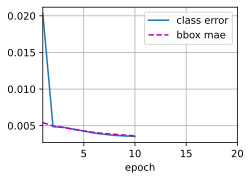

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')


## 14.7.3. Prediction


* 예측 동안 목표는 모든 관심있는 객체를 감지하는 것.
* Test Image를 읽고, Size를 변경하여, Convolutional Layers를 통해 4차원의 Tensor로 변환(Converting)


In [ ]:
X = torchvision.io.read_image('/content/drive/MyDrive/d2l/img/banana.jpg' if bUseColab else '../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

* `multibox_detection` function를 사용하여, predicted bounding boxes를 얻음.
* NMS(non-Maximum suppression)을 사용하여 유사한 predicted bounding boxes 제거.

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

* 최종적으로 Threshold=0.9로 설정하여 Confidence가 0.9이상인 predicted bounding boxes를 표시.

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)


## 14.7.4. Summary


* Single shot multibox detection은 multiscale object detection 모델입니다.   
* base network와 several multiscale feature map blocks을 통해 단일 샷 다중 상자 감지는 크기가 다른 다양한 수의 앵커 박스를 생성하고 이러한 앵커 박스(따라서 bounding boxes)의 Class와 Offset을 예측하여 다양한 크기의 객체를 감지합니다.  

* single-shot multibox detection model을 학습할 때, 앵커 박스 클래스 및 오프셋의 예측 및 레이블링된 값을 기반으로 손실 함수가 계산됩니다.


## 14.7.5. Exercises

1. 손실 함수를 변경하여 single-shot multibox detection를 개선할 수 있습니까?  
    예를 들어, 예측된 Offsets을 위해 $\ell_1$ norm loss를 smooth $\ell_1$ norm loss로 대체하면?   
    이 손실 함수는 0 주변에 제곱 함수를 사용하여 Smoothness하도록 한다.   
    hyper parameter $\sigma$ 값을 이용해 제어 된다.

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

$\sigma$ 값이 커질 수록, 이 Loss 함수는 $\ell_1$ norm loss과 유사해 진다.
$\sigma$ 값이 작아질 수록, 이 Loss 함수는 더 Smooth해 진다.


In [ ]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

* 추가로, class prediction을 위해 cross-entropy loss를 사용하였는데,   
  ground-truth class $j$ 에 대한 predicted probability $p_j$ 대신, $-\log p_j$ 로 변경해 보면?
# 
* 또는 focal loss:cite:`Lin.Goyal.Girshick.ea.2017`를 사용 할 수도 있다. $$ - \alpha (1-p_j)^{\gamma} \log p_j.$$ , where hyperparameters $\gamma > 0$ and $\alpha > 0$


* $\gamma$를 증가시킴에 따라, 분류 시 relative loss를 효과적으로 줄일 수 있다.  
  그래서 훈련은 잘 못 분류 된 어려운 예시들에 대해 조금 더 집중할 수 있습니다.


In [ ]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();

* 공간 제한으로 인해 이 섹션에서는 단일 샷 다중 상자 감지 모델의 구현 세부 정보를 생략했습니다. 다음과 같은 측면에서 모델을 더욱 개선할 수 있습니까?

    1. 객체가 이미지에 비해 훨씬 작은 경우 모델은 입력 이미지의 크기를 더 크게 조정할 수 있습니다.

    1. 일반적으로 수많은 네거티브 앵커 박스가 있습니다. 클래스 분포를 보다 균형 있게 만들기 위해 네거티브 앵커 상자를 다운샘플링할 수 있습니다.

    1. 손실 함수에서 클래스 손실과 오프셋 손실에 서로 다른 가중치 하이퍼파라미터를 할당합니다.

    1. 단일 샷 멀티박스 탐지 논문 [ Liu et al., 2016 ] 과 같이, 객체 검출 모델을 평가하기 위한 다른 방법을 사용해 봅니다. 

[Discussions](https://discuss.d2l.ai/t/1604)
